# Wrangling Twitter data
In this notebook, we are going to start out with the raw Twitter data that was captured using the Tweepy tool on which you can read more about in [this notebook](twitter_scraper.ipynb). The data captured was restricted to tweets from Calgary from December 18 2018 to December 27 2018. 

In order to prep the data for analysis, we will "wrangle" the data to clean it and structure it into a more useful format. 

## Goal: 
Learn some common aspects of data wrangling and convert the data set into a format more practical for further data exploration and analysis. 


## Data wrangling introduction
[Data wrangling](https://en.wikipedia.org/wiki/Data_wrangling) "is the process of transforming and mapping data from one "raw" data form into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes such as analytics" (Wikipedia).

The purpose of data wrangling notebook is to transform complex data into a format that is easier to work with in order to focus on the analysis of data, rather than the wrangling in the next notebooks. 

#### Common data wrangling steps:
 - **Discovering**  - understanding the data
 - **Structuring** -  organizing the data
     - Naming or renaming variables
     - Changing the type of variables
     - Creating new variables through functions of existing of variables
     - Conditional processing of variables (i.e the values of new variable is based on the values of existing variables) 
 - **Cleaning** 
     - Redesign the data into a usable/functional format and correct/remove any bad data
     - Imputing missing values in a variables
 - **Publishing**
    - Selecting columns from input dataset to output dataset


## Load python modules

There are many packages available in Python that provide a variety of functions for data science. Here we load the libraries needed for this notebook. 

One of the most common libraries used for data science is [pandas](https://pandas.pydata.org/). There are good tutorials available on pandas and worthwhile spending more time with in order to become more comfortable with data science in python. 

In [1]:
try:
    import urllib.request
except ImportError:
    !pip install  --user urllib
    import urllib.request

try:
    import ast
except ImportError:
    !pip install  --user ast
    import ast
    
try:
    import pandas as pd
except ImportError:
    !pip install  --user pandas
    import pandas as pd

try:    
    import matplotlib.pyplot as plt
except ImportError:
    !pip install --user matplotlib
    import matplotlib.pyplot as plt

%matplotlib inline

## Step 1. Taking a look at the raw data


#### Reading the Twitter data  and displaying the first 5 rows

The raw data(`tweets.txt`) is stored in the same directory, we will read it into a pandas DataFrame. A **DataFrame** is a commonly encountered way to work with data in data science. It can be thought of as a 2D data structure that makes it easy to work with the data at hand. 

In [2]:
file_name="alberta_tweets.txt"
tweets = []
with open(file_name, 'r') as f:
    for lines in f.readlines():
        tweets.append(ast.literal_eval(lines))
frame  = pd.DataFrame(tweets)
frame.head(3) # head is a convenient way for showing the first few rows of a dataframe

,coordinates,created_at,extended_tweet,hashtags,lang,name,screen_name,text,user_location,user_mentions
0,None,Tue Dec 18 17:23:54 +0000 2018,@CallawayGolfEU The crows nest hands down! #xm...,"[{'indices': [43, 48], 'text': 'xmas'}, {'indi...",en,jeff ullock,JeffUllock,@CallawayGolfEU The crows nest hands down! #xm...,None,"[{'name': 'Callaway Golf Europe', 'id': 230511..."
1,None,Tue Dec 18 17:24:19 +0000 2018,Does anyone know of any high schools that have...,"[{'indices': [80, 97], 'text': 'highschooldesi...",en,Jackie Bouck,JackieBouck,Does anyone know of any high schools that have...,"Kitscoty, Alberta",[]
2,None,Tue Dec 18 17:24:30 +0000 2018,@miss9afi That's blasphemy law you can say it...,[],en,Faiz Ali Qureshi 🇨🇦,FKamranAB,@miss9afi That's blasphemy law you can say it...,"Alberta, Canada","[{'name': 'Ensaf haidar ⚜️🍁', 'id': 309187913,..."


#### Understanding the raw data

Let's take a look at some basic features of the raw data. For example, it's always a good idea to look at the columnns and the size of the data in question. 

In [3]:
frame.columns

Index(['coordinates', 'created_at', 'extended_tweet', 'hashtags', 'lang',
       'name', 'screen_name', 'text', 'user_location', 'user_mentions'],
      dtype='object')

In [4]:
frame.shape

(32598, 10)

Taking a more complete look at the data, here the size of the DataFrame are printed, along with the: 
* column name
* column type
* sample value in the column

In [5]:
print("Number of rows/columns:",frame.shape, "\n")
for column in frame.columns:
    if column=="user_mentions":
        rownum=1
    else :
        rownum=2
    print("Column name: {colname} \nColumn type: {coltype} \nColumn data(example): {coldata} \n\n"
          .format(colname=column, coltype=type(frame[column].iloc[rownum]),coldata=frame[column].iloc[rownum]))

Number of rows/columns: (32598, 10) 

Column name: coordinates 
Column type: <class 'NoneType'> 
Column data(example): None 


Column name: created_at 
Column type: <class 'str'> 
Column data(example): Tue Dec 18 17:24:30 +0000 2018 


Column name: extended_tweet 
Column type: <class 'str'> 
Column data(example): @miss9afi That's blasphemy law you can say  it's like holocaust law in some west countries to avoid disrespect of Holy prophets,
Asia bibi is free now,
As far zakat concerned if someone doesn't want deductions of zakat they are allowed not to get deducted 
No sharia law implemented there 


Column name: hashtags 
Column type: <class 'list'> 
Column data(example): [] 


Column name: lang 
Column type: <class 'str'> 
Column data(example): en 


Column name: name 
Column type: <class 'str'> 
Column data(example): Faiz Ali Qureshi 🇨🇦 


Column name: screen_name 
Column type: <class 'str'> 
Column data(example): FKamranAB 


Column name: text 
Column type: <class 'str'> 
Column dat

There are several interesting features there, such as latitude and longitude of the tweets (`coordinates` column), and most of the columns make sense and are pretty intuitive. Two columns that are a bit confusing are `text` and `extended_tweet` as it looks like they may contain the same content. We should figure out if they are actually different. 

### Indexing in DataFrames

DataFrames are convenient for working with data and are popular both in Python and R. There are a few different ways for accessing data inside a DataFrame. We'll cover a couple of aspects here, but you may also want to read more in the  pandas documentation or cheat sheet such as the one handed out [here](https://www.dataquest.io/blog/large_files/pandas-cheat-sheet.pdf). 

In [6]:
pd.set_option('display.max_row', 10) #Ensure only 10 rows are displayed to save space
pd.set_option('display.max_colwidth', -1) #Ensure output is not truncated by width

#Selecting a column
frame[["text"]] #Using two brackets displays the column as a dataframe

,text
0,@CallawayGolfEU The crows nest hands down! #xmas #nicelist
1,"Does anyone know of any high schools that have pods for Grade 10, 11, and/or 12?#highschooldesign"
2,@miss9afi That's blasphemy law you can say it's like holocaust law in some west countries to avoid disrespect of H… https://t.co/HFJFtIGl9z
3,Albertans voted for @ABLiberal in 1993-2012 they were official opposition. Nearly 40% of votes went to Alberta Libe… https://t.co/suSTHy301I
4,"Dear god you people are dumb! Their members are already elected, they don’t need to run nominations! I can’t believ… https://t.co/s0VEkeiPEZ"
...,...
32593,Almost done a page before work Dx #DaemonsVenatus #4UComics https://t.co/vIwCLQAB03
32594,What a complete disgrace. What a complete waste of tax payers dollars.
32595,Thinking about going to Otafest this year......
32596,FUCK NO


In [7]:
#Selecting two columns 
frame[["text", "extended_tweet"]]

,text,extended_tweet
0,@CallawayGolfEU The crows nest hands down! #xmas #nicelist,@CallawayGolfEU The crows nest hands down! #xmas #nicelist
1,"Does anyone know of any high schools that have pods for Grade 10, 11, and/or 12?#highschooldesign","Does anyone know of any high schools that have pods for Grade 10, 11, and/or 12?#highschooldesign"
2,@miss9afi That's blasphemy law you can say it's like holocaust law in some west countries to avoid disrespect of H… https://t.co/HFJFtIGl9z,"@miss9afi That's blasphemy law you can say it's like holocaust law in some west countries to avoid disrespect of Holy prophets,\nAsia bibi is free now,\nAs far zakat concerned if someone doesn't want deductions of zakat they are allowed not to get deducted \nNo sharia law implemented there"
3,Albertans voted for @ABLiberal in 1993-2012 they were official opposition. Nearly 40% of votes went to Alberta Libe… https://t.co/suSTHy301I,"Albertans voted for @ABLiberal in 1993-2012 they were official opposition. Nearly 40% of votes went to Alberta Liberals in 1993, that was 32 seats. Ralph Klein got a scare. 2019 election shouldn’t be about UCP or NDP @Dave_Khan @alekssamardzija"
4,"Dear god you people are dumb! Their members are already elected, they don’t need to run nominations! I can’t believ… https://t.co/s0VEkeiPEZ","Dear god you people are dumb! Their members are already elected, they don’t need to run nominations! I can’t believe I am having to explain this to a political party and yet here we are."
...,...,...
32593,Almost done a page before work Dx #DaemonsVenatus #4UComics https://t.co/vIwCLQAB03,Almost done a page before work Dx #DaemonsVenatus #4UComics https://t.co/vIwCLQAB03
32594,What a complete disgrace. What a complete waste of tax payers dollars.,What a complete disgrace. What a complete waste of tax payers dollars.
32595,Thinking about going to Otafest this year......,Thinking about going to Otafest this year......
32596,FUCK NO,FUCK NO


In [8]:
#Selecting row subsets
selecttwo = frame[["text", "extended_tweet"]].iloc[[2,5]] #iloc allows for selection by integers
selectrange = frame[["text", "extended_tweet"]].iloc[2:5]

display(selecttwo)
display(selectrange)

,text,extended_tweet
2,@miss9afi That's blasphemy law you can say it's like holocaust law in some west countries to avoid disrespect of H… https://t.co/HFJFtIGl9z,"@miss9afi That's blasphemy law you can say it's like holocaust law in some west countries to avoid disrespect of Holy prophets,\nAsia bibi is free now,\nAs far zakat concerned if someone doesn't want deductions of zakat they are allowed not to get deducted \nNo sharia law implemented there"
5,"@ColemanDeverne Do your thing, but be prepared for the consequences. ;)","@ColemanDeverne Do your thing, but be prepared for the consequences. ;)"


,text,extended_tweet
2,@miss9afi That's blasphemy law you can say it's like holocaust law in some west countries to avoid disrespect of H… https://t.co/HFJFtIGl9z,"@miss9afi That's blasphemy law you can say it's like holocaust law in some west countries to avoid disrespect of Holy prophets,\nAsia bibi is free now,\nAs far zakat concerned if someone doesn't want deductions of zakat they are allowed not to get deducted \nNo sharia law implemented there"
3,Albertans voted for @ABLiberal in 1993-2012 they were official opposition. Nearly 40% of votes went to Alberta Libe… https://t.co/suSTHy301I,"Albertans voted for @ABLiberal in 1993-2012 they were official opposition. Nearly 40% of votes went to Alberta Liberals in 1993, that was 32 seats. Ralph Klein got a scare. 2019 election shouldn’t be about UCP or NDP @Dave_Khan @alekssamardzija"
4,"Dear god you people are dumb! Their members are already elected, they don’t need to run nominations! I can’t believ… https://t.co/s0VEkeiPEZ","Dear god you people are dumb! Their members are already elected, they don’t need to run nominations! I can’t believe I am having to explain this to a political party and yet here we are."


In [9]:
#Select a certain row, all columns
frame.iloc[3,:]

coordinates       None                                                                                                                                                                                                                                                
created_at        Tue Dec 18 17:24:44 +0000 2018                                                                                                                                                                                                                      
extended_tweet    Albertans voted for @ABLiberal in 1993-2012 they were official opposition. Nearly 40% of votes went to Alberta Liberals in 1993, that was 32 seats. Ralph Klein got a scare. 2019 election shouldn’t be about UCP or NDP @Dave_Khan @alekssamardzija
hashtags          []                                                                                                                                                                                               

#### Exercise: Use another method for displaying the same data as above (i.e. all columns of row 3) 

The answer should look as above or capture the same data

In [10]:
###### Enter your code below



#### Investigating `text` and `extended_tweet` graphically

Another way to investigate the difference between `text` and `extended_tweet` is to plot the length distribution for both columns. To do this, we use the [matplotlib library](https://matplotlib.org/) (another very common library used in data science). 

Text(0.5,0,'Tweet length')

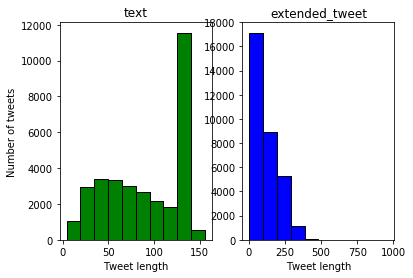

In [11]:
#Set up a plot with subplots (rows, columns, active plot)
plt.subplot(1, 2, 1) 
#Create a histogram, which counts the number of tweets of each length
plt.hist(frame["text"].apply(len).values, color = 'green' ,edgecolor = 'black')
#Label the plot
plt.title('text')
plt.xlabel('Tweet length')
plt.ylabel('Number of tweets')

# Do the same thing for the second subplot
plt.subplot(1, 2, 2)
plt.hist(frame["extended_tweet"].apply(len).values, color = 'blue', edgecolor = 'black')
plt.title('extended_tweet')
plt.xlabel('Tweet length')

Looks like `extended_tweet` has much longer tweets, up to 800 characters in length, whereas there are no tweets longer than 150 characters in `text`. 

What does the longest tweet look like? To do this, we can easily pull the longest tweet from the DataFrame. 


In [12]:
print("Maximum length for extended_tweet column: ",max(frame["extended_tweet"].apply(len)), "\n")

print("This is the index of the longest tweet:")
print([frame["extended_tweet"].apply(len).idxmax(axis=1)], "\n")

Maximum length for extended_tweet column:  960 

This is the index of the longest tweet:
[7637] 



#### Exercise: Using the index you determined above, add your code to display what the longest tweet looks like in the `text` and `extended_tweet` columns in the cell below.

In [13]:
print("Tweet as seen in the **extended_text** column:\n")
###### Enter your code in place of None below
extended = frame["extended_tweet"].iloc[3817]
######

print(extended)

print("Tweet as seen in the **text** column:\n")
###### Enter your code in place of None below
text_tweet = frame["text"].iloc[3817]
######
print(text_tweet)

Tweet as seen in the **extended_text** column:

Want to really 'sleigh-it' this Christmas? Then consider donating to some of the awesome local charities we've been lucky enough to partner with. @pacificwild @YYCsexualhealth @AARCS_Canada @CalgaryFoodBank @CalgaryReads #yyc #yvr https://t.co/c0UQ3HcUv2
Tweet as seen in the **text** column:

Want to really 'sleigh-it' this Christmas? Then consider donating to some of the awesome local charities we've been… https://t.co/6y2WvfUZlo


The answer should show that the `text` column is the truncated version of `extended_tweet` column.

#### So we have following list of columns:
 - **coordinates** - user coordinates, can be None or Python type Dict(needs to be split to two columns - longitude and latitude)
 - **created_at**  - creation date, Python type String (needs to be converted to type Date + timezone needs to be changed from UTC to MST)
 - **extended_tweet** - tweet text, Python type String
 - **hashtags** - hashtags, Python type List of Dicts(needs to be converted to String)
 - **lang** - language , Python type String
 - **name** - twitter account name, Python type String
 - **screen_name** - screen name, Python type String
 - **text** - truncated tweet text, Python type String
 - **user_location** - location, Python type String
 - **user_mentions** - user mentions, Python type List of Dicts(needs to be converted to String)

## Step 2. (Re-) structuring  the data

One aspect to always pay close attention to is the data type of each column. Overlooking data types and ending up with unexpected types often leads to issues further downstream in the analysis. Here we will go through and change some of the data types to make sure they are what we want them to be. 

As part of the process we will print the original data example and converted data example. To get specific row/column from pandas dataframe we will use following:
> datafarme_name["column_name"].iloc[row_number]

#### Convert column `created_at`  from String to Date and change timezone from UTC to MST

In [14]:
print(frame["created_at"].iloc[2]) ## Print the original data

frame["created_at_date"]= pd.to_datetime(frame["created_at"]) ## convert to timestamp
frame["created_at_date"]=frame["created_at_date"].dt.tz_localize('UTC').dt.tz_convert('MST') ## fix timezone

print(frame["created_at_date"].iloc[2]) ## Print the transformed data

Tue Dec 18 17:24:30 +0000 2018
2018-12-18 10:24:30-07:00


#### Convert column `coordinates` from dictionary to two columns `latitude` and `longitude`

In [15]:
print(frame["coordinates"].head(), "\n") ## Print the original data

def convertCoordToList(v):  ## helper function
    if v is None:
        v=[]
    else:
        v= v['coordinates']
    return v

frame['coordinates_list']= frame['coordinates'].map(convertCoordToList) #Convert coordinates from Dict to List

#Split coordinates_list column into two: latitude and longitude
frame[['latitude','longitude']] = pd.DataFrame(frame['coordinates_list'].values.tolist())

print(frame[['longitude','latitude']].head()) ## Print the transformed data

0    None
1    None
2    None
3    None
4    None
Name: coordinates, dtype: object 

   longitude  latitude
0 NaN        NaN      
1 NaN        NaN      
2 NaN        NaN      
3 NaN        NaN      
4 NaN        NaN      


#### Convert column `hashtags`  from dictionary to strings
If there were no hashtags in a cell, we will fill that cell in our dataframe with a single space `' '`. 

In [27]:
print(frame["hashtags"].iloc[1]) ## Print the original data

def convertHashToString(v): ## helper function
    if v == []:
        v=' '
    else:
        v=' '.join([d['text'] for d in v])
    return v

frame['hashtags_string']= frame['hashtags'].map(convertHashToString) ## Do the conversion

print("\n",frame["hashtags_string"].iloc[2]) ## Print the transformed data

[{'indices': [80, 97], 'text': 'highschooldesign'}]

  


#### Convert column `user_mentions` from dictionary to string

We don't want the `user_mentions` column to be in a dictionary format as it is easier to work with as a string. Let's convert it.

The following is a sample of what the data looks like and what data type it is.

In [29]:
print(frame["user_mentions"].iloc[2]) ## Print the original data + type
print(type(frame["user_mentions"].iloc[2]))

[{'name': 'Ensaf haidar ⚜️🍁', 'id': 309187913, 'screen_name': 'miss9afi', 'id_str': '309187913', 'indices': [0, 9]}]
<class 'list'>


**Exercise:** Using the `hashtags` conversion above as an example, complete the following cell in order to convert the `user_mentions` column to strings. 

In [31]:
def convertUserToString(v):
    if v == []:
        v=' '
    else:
 
        v=' '.join([d['screen_name'] for d in v])
    return v

frame['user_string']= frame['user_mentions'].map(convertUserToString) ## Do the conversion 

#### Check your answer
Only screen_name's should be extracted from the distionary and data type should be str

In [34]:
print(frame["user_string"].iloc[2]) ## Print the transformed data + type
print(type(frame["user_string"].iloc[2]))


miss9afi
<class 'str'>


0        CallawayGolfEU                      
1                                            
2        miss9afi                            
3        ABLiberal                           
4                                            
        ..                                   
32593                                        
32594                                        
32595                                        
32596                                        
32597    Rockchip77 michaelaglasgo albertaNDP
Name: user_string, Length: 32598, dtype: object

## Step 3. Cleaning the data

Some data cleanup was done in step 2. Let's take a closer look at the `extended_tweet` column, since we will use it in further during our data analysis. 

First, let's look at what some of the tweets look like. We'll set an output parameter and then access the first few tweets. 

In [35]:
pd.set_option('max_colwidth', 700) ## Setting col_widht wider - so we can see the entire tweet
frame['extended_tweet'].head(10)

0                                                                                                                                                                                                                                             @CallawayGolfEU The crows nest hands down! #xmas #nicelist
1                                                                                                                                                                                                      Does anyone know of any high schools that have pods for Grade 10, 11, and/or 12?#highschooldesign
2    @miss9afi That's blasphemy law you can say  it's like holocaust law in some west countries to avoid disrespect of Holy prophets,\nAsia bibi is free now,\nAs far zakat concerned if someone doesn't want deductions of zakat they are allowed not to get deducted \nNo sharia law implemented there
3                                                   Albertans voted for @ABLiberal in 1993-2012 they were off

####  Remove URLS 
There are lots of links in this column that might make our future data analysis messy and likely do not have any meaning. Let's remove them together with any links starting with www.  

We will accomplish this using regular expressions (Note that **\S+** means one or more non-whitespace character)

In [36]:
frame['extended_tweet']=frame['extended_tweet'].str.replace('http\S+|www.\S+', '', case=False)

#### Exercise: remove '\n' (new line symbol) from 'extended_tweet' column

Another item that might interfere with our analysis are new line characters. Let's remove these as well in the cell below. 

In [38]:
frame['extended_tweet']=frame['extended_tweet'].str.replace('\n', ' ', case=False)

#### Check your answer
Print the first 10 tweets and see if \n is removed

In [39]:
frame['extended_tweet'].head(10)

0                                                                                                                                                                                                                                          @CallawayGolfEU The crows nest hands down! #xmas #nicelist
1                                                                                                                                                                                                   Does anyone know of any high schools that have pods for Grade 10, 11, and/or 12?#highschooldesign
2    @miss9afi That's blasphemy law you can say  it's like holocaust law in some west countries to avoid disrespect of Holy prophets, Asia bibi is free now, As far zakat concerned if someone doesn't want deductions of zakat they are allowed not to get deducted  No sharia law implemented there
3                                                Albertans voted for @ABLiberal in 1993-2012 they were official opposi

#### Remove user mentions and hashtags from the 'extended_tweet' column and save it as 'extended_tweet_cleaned' column
There are separate columns for user mentions and hashtags. We might need to analyse tweet text without any hashtags/user mentions. However, we might also want to do some analysis on the tweets including the mentions and hashtags. As such, tweets with these items removed will be stored in a separate column. 

In [40]:
frame['extended_tweet_cleaned']=frame['extended_tweet'].str.replace('[@#]\w+', ' ',case=False)
frame['extended_tweet_cleaned'].head(5)

0                                                                                                                                                                                                                                                              The crows nest hands down!    
1                                                                                                                                                                                                           Does anyone know of any high schools that have pods for Grade 10, 11, and/or 12? 
2      That's blasphemy law you can say  it's like holocaust law in some west countries to avoid disrespect of Holy prophets, Asia bibi is free now, As far zakat concerned if someone doesn't want deductions of zakat they are allowed not to get deducted  No sharia law implemented there
3                                                                         Albertans voted for   in 1993-2012 they were official opposition. Ne

We will keep emoji, punctuation,  numbers and special characters for now. They might be useful for the analysis. We can always do more cleaning in the later notebooks

#### Let's take a look at the language column

In [41]:
frame["lang"].unique()

array(['en'], dtype=object)

Column lang has only one value en so it can be safely ignored



## Step 6. Publishing - saving data for future work

In order to work with this data further, let's save a new DataFrame. 

We'll simply select the desired columns from the working dataset into the output dataset and take a look at the output. Does the output match what we expected? How do the `extended_tweet` and `extended_tweet_clean` columns compare? 

Further below, we'll save the data to a csv file. 

In [42]:
frame_cleaned=frame[['created_at_date','hashtags_string','user_string','user_location',
                     'longitude','latitude','name', 'screen_name','extended_tweet','extended_tweet_cleaned']]
frame_cleaned.head()

,created_at_date,hashtags_string,user_string,user_location,longitude,latitude,name,screen_name,extended_tweet,extended_tweet_cleaned
0,2018-12-18 10:23:54-07:00,xmas nicelist,CallawayGolfEU,None,NaN,NaN,jeff ullock,JeffUllock,@CallawayGolfEU The crows nest hands down! #xmas #nicelist,The crows nest hands down!
1,2018-12-18 10:24:19-07:00,highschooldesign,,"Kitscoty, Alberta",NaN,NaN,Jackie Bouck,JackieBouck,"Does anyone know of any high schools that have pods for Grade 10, 11, and/or 12?#highschooldesign","Does anyone know of any high schools that have pods for Grade 10, 11, and/or 12?"
2,2018-12-18 10:24:30-07:00,,miss9afi,"Alberta, Canada",NaN,NaN,Faiz Ali Qureshi 🇨🇦,FKamranAB,"@miss9afi That's blasphemy law you can say it's like holocaust law in some west countries to avoid disrespect of Holy prophets, Asia bibi is free now, As far zakat concerned if someone doesn't want deductions of zakat they are allowed not to get deducted No sharia law implemented there","That's blasphemy law you can say it's like holocaust law in some west countries to avoid disrespect of Holy prophets, Asia bibi is free now, As far zakat concerned if someone doesn't want deductions of zakat they are allowed not to get deducted No sharia law implemented there"
3,2018-12-18 10:24:44-07:00,,ABLiberal,"Calgary, Alberta",NaN,NaN,Irwin Singh Brar,roti888,"Albertans voted for @ABLiberal in 1993-2012 they were official opposition. Nearly 40% of votes went to Alberta Liberals in 1993, that was 32 seats. Ralph Klein got a scare. 2019 election shouldn’t be about UCP or NDP @Dave_Khan @alekssamardzija","Albertans voted for in 1993-2012 they were official opposition. Nearly 40% of votes went to Alberta Liberals in 1993, that was 32 seats. Ralph Klein got a scare. 2019 election shouldn’t be about UCP or NDP"
4,2018-12-18 10:24:48-07:00,,,"Calgary, Alberta",NaN,NaN,Vince,VincentRule,"Dear god you people are dumb! Their members are already elected, they don’t need to run nominations! I can’t believe I am having to explain this to a political party and yet here we are.","Dear god you people are dumb! Their members are already elected, they don’t need to run nominations! I can’t believe I am having to explain this to a political party and yet here we are."


In [43]:
frame_cleaned.to_csv('alberta_tweets_cleaned.csv',index=False)

##  Conclusion

We've taken a preliminary look at some of the raw Twitter data that's been collected in order to further work with it. This included restructuring and reorganizing it and cleaning up the columns that we anticipate needing the most for our analysis.

Take-aways: 
* We've started working with some very popular libraries for doing data science in Python: pandas and matplotlib
* Examining, wrangling, and cleaning your data are important work that will take up large portions of time in the data science workflow
* This is an iterative process. We took a stab at what we need to clean up and refine now, but may very well find things we've missed as we dig deeper into the data. 

Next, we will get into data exploration further. 